# Highway Route 2 is now open.

Highway route0 and rroute 1 have been built [here](https://www.kaggle.com/yamsam/new-ucf-starter-kernel) and [here](https://www.kaggle.com/yamsam/ashrae-highway-kernel-route1).

As you already know there are huge data leak in this competition. Until now site-0, site-1 and site-2 building meter reading data were discovered by great kagglers.
In this kernel I will share all my findings about those leak data to try to keep this competition to be fair for all paticipants.

This Kernel are based on following great kernels:

* [ASHRAE: Training LGBM by meter type](https://www.kaggle.com/corochann/ashrae-training-lgbm-by-meter-type)
* [ASHRAE - UCF Spider and EDA (Full Test Labels)](https://www.kaggle.com/gunesevitan/ashrae-ucf-spider-and-eda-full-test-labels)
* [UCL: Data Leakage (Episode 2)](https://www.kaggle.com/mpware/ucl-data-leakage-episode-2)
* [ASU train and scraped test data](https://www.kaggle.com/pdnartreb/scrap-asu-data)

Thank you corochann and Gunes Evitan and MPWARE and Bertrand P. You are Great Kagglers!!

And also Thanks UCF,UCL and ASU to make great meter reading data public, I have no offence indeed 😅

In [1]:
folds = 5

debug = False
num_rounds=1000

use_ucf  = True  # use ucf data in train
use_sort = True # sort by month
del_2016 = False # delete site0 2016 from train
ucf_year = [2017, 2018] # ucf data year used in train 

# ASHRAE - Great Energy Predictor III


Our aim in this competition is to predict energy consumption of buildings.

There are 4 types of energy to predict:

 - 0: electricity
 - 1: chilledwater
 - 2: steam
 - 3: hotwater

Electricity and water consumption may have different behavior!
So I tried to separately train & predict the model.

I moved previous [ASHRAE: Simple LGBM submission](https://www.kaggle.com/corochann/ashrae-simple-lgbm-submission) kernel.

**[Update] I published "[Optuna tutorial for hyperparameter optimization](https://www.kaggle.com/corochann/optuna-tutorial-for-hyperparameter-optimization)" notebook.
Please also check it :)**

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.metrics import mean_squared_error

In [3]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
!ls ../usr/lib/ucl_data_leakage_episode_2

__notebook__.ipynb  __results__.html   __resultx__.html  site1.pkl
__output__.json     __results___files  custom.css


# Fast data loading

This kernel uses the preprocessed data from my previous kernel, [
ASHRAE: feather format for fast loading](https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading), to accelerate data loading!

In [5]:
%%time
root = Path('../input/ashrae-feather-format-for-fast-loading')

train_df = pd.read_feather(root/'train.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead



CPU times: user 1.92 s, sys: 604 ms, total: 2.52 s
Wall time: 5.36 s


/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



# Leak Data loading and concat

In [6]:
# load site 0 data
ucf_root = Path('../input/ashrae-ucf-spider-and-eda-full-test-labels')
leak0_df = pd.read_pickle(ucf_root/'site0.pkl') 
leak0_df['meter_reading'] = leak0_df.meter_reading_scraped
leak0_df.drop(['meter_reading_original','meter_reading_scraped'], axis=1, inplace=True)
leak0_df.fillna(0, inplace=True)
leak0_df.loc[leak0_df.meter_reading < 0, 'meter_reading'] = 0
leak0_df = leak0_df[leak0_df.timestamp.dt.year > 2016]
print(len(leak0_df))

2260080


In [7]:
leak0_df.head()

,building_id,meter,timestamp,meter_reading
1076662,0,0,2017-01-01,173.370293
1076663,1,0,2017-01-01,53.512720
1076664,2,0,2017-01-01,6.143042
1076665,3,0,2017-01-01,101.701470
1076666,4,0,2017-01-01,1141.240666


In [8]:
# load site 1 data
ucl_root = Path('../usr/lib/ucl_data_leakage_episode_2')
leak1_df = pd.read_pickle(ucl_root/'site1.pkl') 
leak1_df['meter_reading'] = leak1_df.meter_reading_scraped
leak1_df.drop(['meter_reading_scraped'], axis=1, inplace=True)
leak1_df.fillna(0, inplace=True)
leak1_df.loc[leak1_df.meter_reading < 0, 'meter_reading'] = 0
leak1_df = leak1_df[leak1_df.timestamp.dt.year > 2016]
print(len(leak1_df))

876000


In [9]:
leak1_df.head()

,building_id,meter,timestamp,meter_reading
8784,105,0,2017-01-01 00:00:00,21.5155
8785,105,0,2017-01-01 01:00:00,44.6565
8786,105,0,2017-01-01 02:00:00,44.5625
8787,105,0,2017-01-01 03:00:00,45.6715
8788,105,0,2017-01-01 04:00:00,45.2970


In [10]:
# load site 2 data
leak2_df = pd.read_csv('/kaggle/input/asu-buildings-energy-consumption/asu_2016-2018.csv')
leak2_df['timestamp'] = pd.to_datetime(leak2_df['timestamp'])
leak2_df.fillna(0, inplace=True)
leak2_df.loc[leak2_df.meter_reading < 0, 'meter_reading'] = 0
leak2_df = leak2_df[leak2_df.timestamp.dt.year > 2016]
print(len(leak2_df))

5063280


In [11]:
leak2_df.head()

,timestamp,building_id,meter,meter_reading
2530312,2017-01-01,156,0,104.96
2530313,2017-01-01,157,0,32.92
2530314,2017-01-01,158,0,10.97
2530315,2017-01-01,159,0,8.70
2530316,2017-01-01,160,0,10.08


In [12]:
#load Site 5 Data
leak5_df = pd.read_csv('/kaggle/input/ashrae-site15-cornell/site15_leakage.csv')
leak5_df['timestamp'] = pd.to_datetime(leak5_df['timestamp'])
leak5_df.fillna(0, inplace=True)
leak5_df.loc[leak5_df.meter_reading < 0, 'meter_reading'] = 0
leak5_df = leak5_df[leak5_df.timestamp.dt.year > 2016]
print(len(leak5_df))

2476701


In [13]:
leak5_df.head()

,timestamp,meter,meter_reading,building_id,score
0,2017-01-01 00:00:00,0.0,27.650000,1429,1.0
1,2017-01-01 00:00:00,2.0,278.528900,1426,1.0
2,2017-01-01 01:00:00,0.0,28.674999,1429,1.0
3,2017-01-01 01:00:00,2.0,373.365875,1426,1.0
4,2017-01-01 02:00:00,0.0,27.200001,1429,1.0


In [14]:
print ('New leak rate = {}'.format((len(leak0_df) + len(leak1_df) + len(leak2_df) + len(leak5_df))  / len(train_df)))

New leak rate = 0.5280969623221096


In [15]:
if use_ucf:
    if del_2016:
        print('delete all buildings site0 in 2016')
        bids = leak_df.building_id.unique()
        train_df = train_df[train_df.building_id.isin(bids) == False]

    leak0_df = leak0_df[leak0_df.timestamp.dt.year.isin(ucf_year)]
    leak1_df = leak1_df[leak1_df.timestamp.dt.year.isin(ucf_year)]
    leak2_df = leak2_df[leak2_df.timestamp.dt.year.isin(ucf_year)]
    leak5_df = leak5_df[leak5_df.timestamp.dt.year.isin(ucf_year)]
    
    train_df = pd.concat([train_df, leak0_df, leak1_df, leak2_df,leak5_df])
    train_df.reset_index(inplace=True)
    
    weather_train_df = pd.concat([weather_train_df, weather_test_df])
    weather_train_df.reset_index(inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [16]:
del weather_test_df, leak0_df, leak1_df, leak2_df, leak5_df #leak_meta_df
gc.collect()

77

In [17]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [18]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = px.line(train_temp_df_meter, x='date', y='meter_reading_log1p')
    fig.show()

In [19]:
plot_date_usage(train_df, meter=0, building_id=0)

In [20]:
plot_date_usage(train_df, meter=0, building_id=105)

In [21]:
plot_date_usage(train_df, meter=0, building_id=156)

## Removing weired data on site_id 0

As you can see above, this data looks weired until May 20. It is reported in [this discussion](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588) by @barnwellguy that **All electricity meter is 0 until May 20 for site_id == 0**. I will remove these data from training data.

It corresponds to `building_id <= 104`.

In [22]:
# eliminate bad rows
bad_rows = pd.read_csv('/kaggle/input/rows-to-drop/rows_to_drop.csv')
train_df.drop(bad_rows.loc[:, '0'], inplace = True)
train_df.reset_index(drop = True, inplace = True)

# Data preprocessing

Now, Let's try building GBDT (Gradient Boost Decision Tree) model to predict `meter_reading_log1p`. I will try using LightGBM in this notebook.

# FIX Time Zone

In [23]:
zone_dict={0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4} 

def set_localtime(df):
    for sid, zone in zone_dict.items():
        sids = df.site_id == sid
        df.loc[sids, 'timestamp'] = df[sids].timestamp - pd.offsets.Hour(zone)

# Add time feature

Some features introduced in https://www.kaggle.com/ryches/simple-lgbm-solution by @ryches

Features that are likely predictive:

#### Weather

- time of day
- holiday
- weekend
- cloud_coverage + lags
- dew_temperature + lags
- precip_depth + lags
- sea_level_pressure + lags
- wind_direction + lags
- wind_speed + lags

#### Train

- max, mean, min, std of the specific building historically



However we should be careful of putting time feature, since we have only 1 year data in training,
including `date` makes overfiting to training data.

How about `month`? It may be better to check performance by cross validation.
I go not using this data in this kernel for robust modeling.

In [24]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month

In [25]:
preprocess(train_df)

In [26]:
# sort train. i dont know it is best
if use_ucf and use_sort:
    train_df = train_df.sort_values('month')
    train_df = train_df.reset_index()

In [27]:
df_group = train_df.groupby('building_id')['meter_reading_log1p']

building_median = df_group.median().astype(np.float16)

train_df['building_median'] = train_df['building_id'].map(building_median)

del df_group

# Fill Nan value in weather dataframe by interpolation


weather data has a lot of NaNs!!

![](http://)I tried to fill these values by **interpolating** data.

In [28]:
weather_train_df.head()

,index,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0
1,1,0,2016-01-01 01:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5
2,2,0,2016-01-01 02:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,3,0,2016-01-01 03:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,4,0,2016-01-01 04:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [29]:
weather_train_df.isna().sum()

index                      0
site_id                    0
timestamp                  0
air_temperature          159
cloud_coverage        209621
dew_temperature          440
precip_depth_1_hr     145877
sea_level_pressure     31883
wind_direction         18638
wind_speed               764
dtype: int64

In [30]:
weather_train_df.shape

(417016, 10)

In [31]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,index,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,,
0,0,0,0,3,11373,3,31,394,727,2
1,0,0,0,23,20735,23,26050,117,8,0
2,0,0,0,1,7799,3,87,77,1784,14
3,0,0,0,6,11493,9,81,534,405,12
4,0,0,0,0,12260,5,1599,192,309,0
5,0,0,0,2,17375,3,25996,25996,830,4
6,0,0,0,14,9460,14,44,564,2191,90
7,0,0,0,0,25187,74,22659,50,0,0
8,0,0,0,3,11373,3,31,394,727,2


In [32]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [33]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,index,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,26050,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,25996,25996,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,25187,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0


Seems number of nan has reduced by `interpolate` but some property has never appear in specific `site_id`, and nan remains for these features.

## lags

Adding some lag feature

In [34]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [35]:
set_localtime(weather_train_df)

In [36]:
weather_train_df.head()

,index,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2015-12-31 20:00:00,25.000000,6.0,20.0,-1.0,1019.700012,0.0,0.0
1,1,0,2015-12-31 21:00:00,24.400000,4.0,21.1,-1.0,1020.200012,70.0,1.5
2,2,0,2015-12-31 22:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,3,0,2015-12-31 23:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,4,0,2016-01-01 00:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [37]:
weather_train_df.columns

Index(['index', 'site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')

In [38]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


0

In [39]:
train_df = reduce_mem_usage(train_df, use_float16=True)
building_meta_df = reduce_mem_usage(building_meta_df, use_float16=True)
weather_train_df = reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 2795.01 MB
Memory usage after optimization is: 998.26 MB
Decreased by 64.3%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 24.1%
Memory usage of dataframe is 17.90 MB
Memory usage after optimization is: 10.74 MB
Decreased by 40.0%


In [40]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


# Train model

To win in kaggle competition, how to evaluate your model is important.
What kind of cross validation strategy is suitable for this competition? This is time series data, so it is better to consider time-splitting.

However this notebook is for simple tutorial, so I will proceed with KFold splitting without shuffling, so that at least near-term data is not included in validation.

In [41]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend',
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed' ]

In [42]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

In [43]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,

              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [44]:
#folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
oof_total = 0

# Train model by each meter type

target_meter 0 (17638402, 15)
cat_features [12, 13, 14]
train 14110721 valid 3527681
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.570831	valid_1's l2: 0.525959
[40]	training's l2: 0.320443	valid_1's l2: 0.29167
[60]	training's l2: 0.269253	valid_1's l2: 0.249664
[80]	training's l2: 0.250519	valid_1's l2: 0.240116
[100]	training's l2: 0.238543	valid_1's l2: 0.232911
[120]	training's l2: 0.230702	valid_1's l2: 0.227196
[140]	training's l2: 0.22536	valid_1's l2: 0.223269
[160]	training's l2: 0.221706	valid_1's l2: 0.220795
[180]	training's l2: 0.218971	valid_1's l2: 0.219569
[200]	training's l2: 0.216761	valid_1's l2: 0.218448
[220]	training's l2: 0.21509	valid_1's l2: 0.217668
[240]	training's l2: 0.213723	valid_1's l2: 0.21756
[260]	training's l2: 0.212286	valid_1's l2: 0.21719
[280]	training's l2: 0.211016	valid_1's l2: 0.216534
[300]	training's l2: 0.209984	valid_1's l2: 0.216497
Early stopping, best iteration is:
[290]	training's l2: 0.210502	valid_1's l2: 0.216351
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.210

15

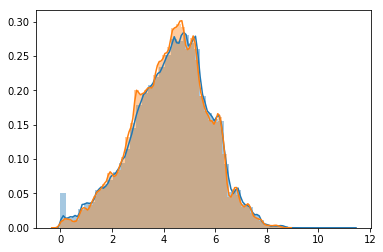

In [45]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=num_rounds, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof0 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof0 * len(y_train)

del X_train, y_train
gc.collect()

In [46]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

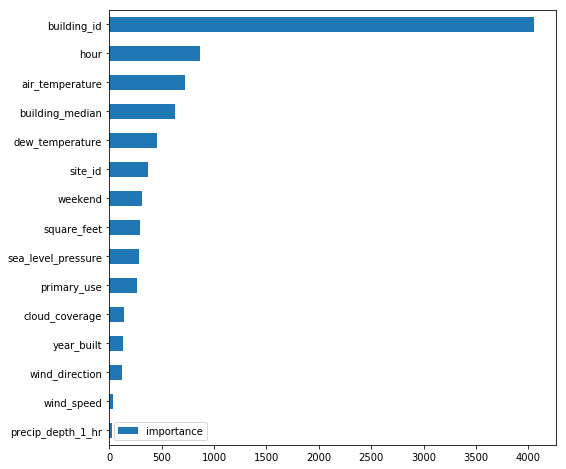

In [47]:
plot_feature_importance(models0[0])

target_meter 1 (6782661, 15)
cat_features [12, 13, 14]
train 5426128 valid 1356533
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.05372	valid_1's l2: 2.70961
[40]	training's l2: 1.44507	valid_1's l2: 1.98228
[60]	training's l2: 1.26654	valid_1's l2: 1.78516
[80]	training's l2: 1.19094	valid_1's l2: 1.70569
[100]	training's l2: 1.14133	valid_1's l2: 1.6597
[120]	training's l2: 1.11449	valid_1's l2: 1.63508
[140]	training's l2: 1.09328	valid_1's l2: 1.61918
[160]	training's l2: 1.07806	valid_1's l2: 1.60692
[180]	training's l2: 1.06394	valid_1's l2: 1.59868
[200]	training's l2: 1.05176	valid_1's l2: 1.59188
[220]	training's l2: 1.04228	valid_1's l2: 1.5867
[240]	training's l2: 1.03334	valid_1's l2: 1.58005
[260]	training's l2: 1.02611	valid_1's l2: 1.57748
[280]	training's l2: 1.02037	valid_1's l2: 1.57633
[300]	training's l2: 1.01413	valid_1's l2: 1.5752
[320]	training's l2: 1.00918	valid_1's l2: 1.57321
[340]	training's l2: 1.00452	valid_1's l2: 1.57167
[360]	training's l2: 1.00021	valid_1's l2: 1.57001
[380]	training's l2: 0.9958

15

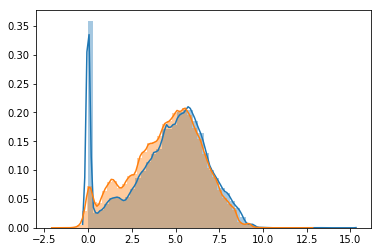

In [48]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=num_rounds,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof1 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof1 * len(y_train)

del X_train, y_train
gc.collect()

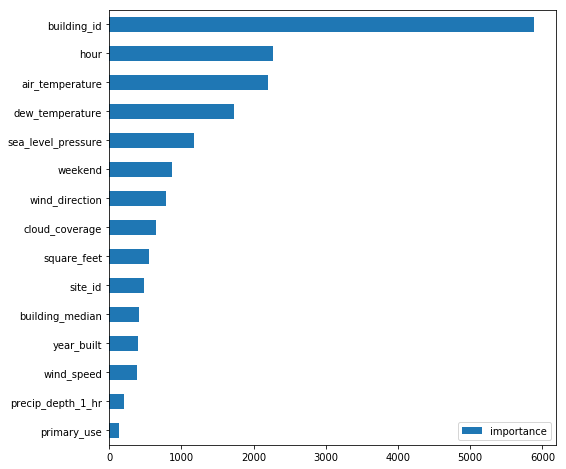

In [49]:
plot_feature_importance(models1[0])

target_meter 2 (3368076, 15)
cat_features [12, 13, 14]
train 2694460 valid 673616
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.21906	valid_1's l2: 1.96983
[40]	training's l2: 1.58538	valid_1's l2: 1.29961
[60]	training's l2: 1.42989	valid_1's l2: 1.14524
[80]	training's l2: 1.36179	valid_1's l2: 1.08332
[100]	training's l2: 1.319	valid_1's l2: 1.05602
[120]	training's l2: 1.28937	valid_1's l2: 1.03935
[140]	training's l2: 1.26592	valid_1's l2: 1.03046
[160]	training's l2: 1.24681	valid_1's l2: 1.02381
[180]	training's l2: 1.2333	valid_1's l2: 1.01626
[200]	training's l2: 1.21849	valid_1's l2: 1.01015
[220]	training's l2: 1.20611	valid_1's l2: 1.00489
[240]	training's l2: 1.19648	valid_1's l2: 0.999437
[260]	training's l2: 1.18658	valid_1's l2: 0.996377
[280]	training's l2: 1.17701	valid_1's l2: 0.992911
[300]	training's l2: 1.16773	valid_1's l2: 0.989996
[320]	training's l2: 1.15793	valid_1's l2: 0.988657
[340]	training's l2: 1.15136	valid_1's l2: 0.985557
[360]	training's l2: 1.14421	valid_1's l2: 0.984037
[380]	training's l2:

15

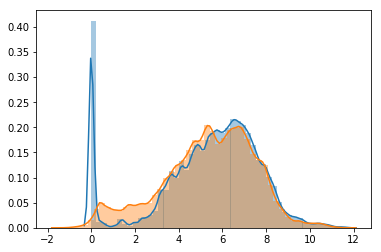

In [50]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=num_rounds, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof2 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof2 * len(y_train)

del X_train, y_train
gc.collect()

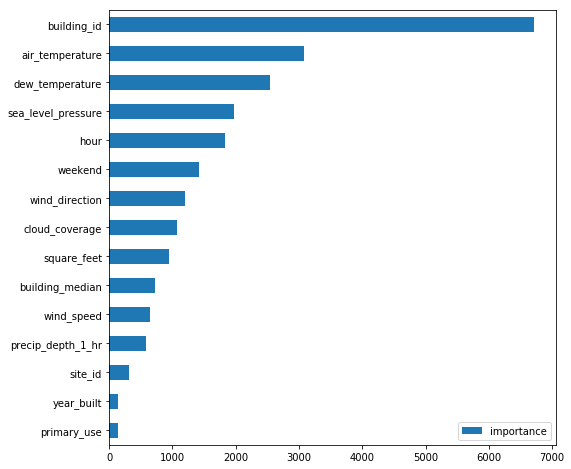

In [51]:
plot_feature_importance(models2[0])

target_meter 3 (2116763, 15)
cat_features [12, 13, 14]
train 1693410 valid 423353
training LGB:


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.94146	valid_1's l2: 3.22009
[40]	training's l2: 2.07299	valid_1's l2: 2.34796
[60]	training's l2: 1.76645	valid_1's l2: 1.98701
[80]	training's l2: 1.6363	valid_1's l2: 1.82839
[100]	training's l2: 1.57042	valid_1's l2: 1.75528
[120]	training's l2: 1.5273	valid_1's l2: 1.70547
[140]	training's l2: 1.49724	valid_1's l2: 1.67632
[160]	training's l2: 1.4741	valid_1's l2: 1.66
[180]	training's l2: 1.45559	valid_1's l2: 1.64977
[200]	training's l2: 1.44068	valid_1's l2: 1.64228
[220]	training's l2: 1.4282	valid_1's l2: 1.63898
[240]	training's l2: 1.41714	valid_1's l2: 1.63875
[260]	training's l2: 1.40744	valid_1's l2: 1.63638
Early stopping, best iteration is:
[259]	training's l2: 1.40786	valid_1's l2: 1.63607
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.4078563267063966}, 'valid_1': {'l2': 1.6360673199091786}})
train 1693410 valid 423353
training LGB:
Training until validation scores don't 

15

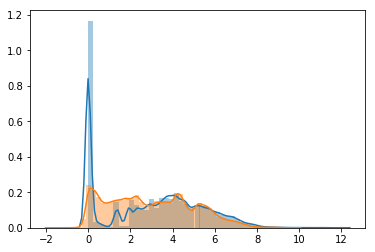

In [52]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=num_rounds,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_valid_pred_total)

oof3 = mean_squared_error(y_train, y_valid_pred_total)
oof_total += oof3 * len(y_train)

del X_train, y_train
gc.collect()

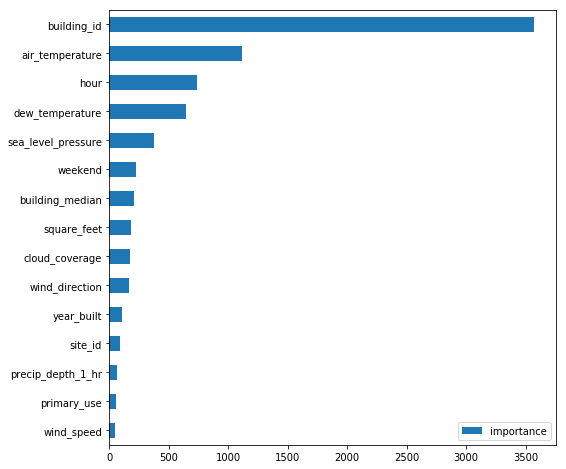

In [53]:
plot_feature_importance(models3[0])

# OOF SCOREs

In [54]:
print ('oof score meter0 =', np.sqrt(oof0))
print ('oof score meter1 =', np.sqrt(oof1))
print ('oof score meter2 =', np.sqrt(oof2))
print ('oof score meter3 =', np.sqrt(oof3))
print ('oof score total  =', np.sqrt(oof_total / len(train_df)))

oof score meter0 = 0.49275688562214465
oof score meter1 = 1.1264362281613882
oof score meter2 = 1.1630398539955646
oof score meter3 = 1.2968260594555328
oof score total  = 0.8380701532863033


# Prediction on test data

In [55]:
del train_df, weather_train_df, building_meta_df 
gc.collect()

11373

In [56]:
print('loading...')
test_df = pd.read_feather(root/'test.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

set_localtime(weather_test_df)

print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)

test_df['building_median'] = test_df['building_id'].map(building_median)

print('preprocessing weather...')
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

print('reduce mem usage...')
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...


/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 1948.53 MB
Memory usage after optimization is: 874.88 MB
Decreased by 55.1%
Memory usage of dataframe is 9.78 MB
Memory usage after optimization is: 6.08 MB
Decreased by 37.8%


0

In [57]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
reduce_mem_usage(sample_submission)

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning:

`nthreads` argument is deprecated, pass `use_threads` instead

/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.



Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [58]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [59]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total


iterations 25
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 1h 4min 29s, sys: 35.7 s, total: 1h 5min 5s
Wall time: 17min 26s


10

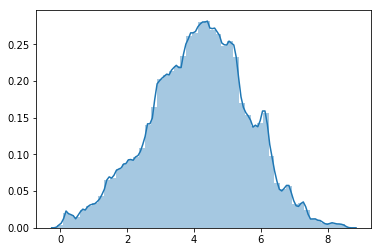

In [60]:
%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

iterations 9
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 37min 8s, sys: 12.4 s, total: 37min 20s
Wall time: 9min 50s


25

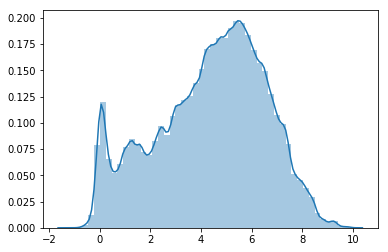

In [61]:
%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

iterations 6
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



CPU times: user 22min, sys: 7.95 s, total: 22min 8s
Wall time: 5min 50s


22

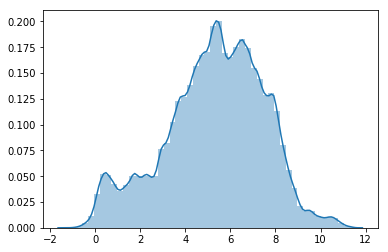

In [62]:
%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


19

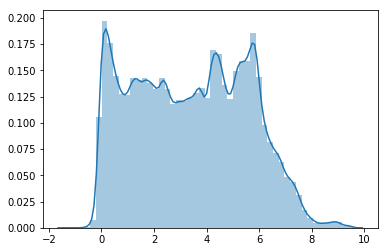

In [63]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

In [64]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [65]:
if not debug:
    sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

# Replace to Leak data

In [66]:
# sie 0
leak_score0 = 0

leak_df = pd.read_pickle(ucf_root/'site0.pkl') 
leak_df['meter_reading'] = leak_df.meter_reading_scraped
leak_df.drop(['meter_reading_original','meter_reading_scraped'], axis=1, inplace=True)
leak_df.fillna(0, inplace=True)
leak_df = leak_df[leak_df.timestamp.dt.year > 2016]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values

sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

for bid in leak_df.building_id.unique():
    temp_df = leak_df[(leak_df.building_id == bid)]
    for m in temp_df.meter.unique():
        v0 = sample_submission.loc[(test_df.building_id == bid)&(test_df.meter==m), 'meter_reading'].values
        v1 = temp_df[temp_df.meter==m].meter_reading.values
        
        leak_score0 += mean_squared_error(np.log1p(v0), np.log1p(v1)) * len(v0)
        
        sample_submission.loc[(test_df.building_id == bid)&(test_df.meter==m), 'meter_reading'] = temp_df[temp_df.meter==m].meter_reading.values
        
leak_score0 /= len(leak_df)

In [67]:
# site 1
leak_score1 = 0

leak_df = pd.read_pickle(ucl_root/'site1.pkl') 
leak_df['meter_reading'] = leak_df.meter_reading_scraped
leak_df.drop(['meter_reading_scraped'], axis=1, inplace=True)
leak_df.fillna(0, inplace=True)
leak_df = leak_df[leak_df.timestamp.dt.year > 2016]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values

#sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

for bid in leak_df.building_id.unique():
    temp_df = leak_df[(leak_df.building_id == bid)]
    for m in temp_df.meter.unique():
        v0 = sample_submission.loc[(test_df.building_id == bid)&(test_df.meter==m), 'meter_reading'].values
        v1 = temp_df[temp_df.meter==m].meter_reading.values
        
        leak_score1 += mean_squared_error(np.log1p(v0), np.log1p(v1)) * len(v0)
        
        sample_submission.loc[(test_df.building_id == bid)&(test_df.meter==m), 'meter_reading'] = temp_df[temp_df.meter==m].meter_reading.values

leak_score1 /= len(leak_df)        

In [68]:
# site 2
leak_score2 = 0

leak_df = pd.read_csv('/kaggle/input/asu-buildings-energy-consumption/asu_2016-2018.csv')
leak_df['timestamp'] = pd.to_datetime(leak_df['timestamp'])
leak_df.fillna(0, inplace=True)
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0
leak_df = leak_df[leak_df.timestamp.dt.year > 2016]

for bid in leak_df.building_id.unique():
    temp_df = leak_df[(leak_df.building_id == bid)]
    for m in temp_df.meter.unique():
        v0 = sample_submission.loc[(test_df.building_id == bid)&(test_df.meter==m), 'meter_reading'].values
        v1 = temp_df[temp_df.meter==m].meter_reading.values
        
        leak_score2 += mean_squared_error(np.log1p(v0), np.log1p(v1)) * len(v0)
        
        sample_submission.loc[(test_df.building_id == bid)&(test_df.meter==m), 'meter_reading'] = temp_df[temp_df.meter==m].meter_reading.values

leak_score2 /= len(leak_df)        

In [69]:
if not debug:
    sample_submission.to_csv('submission_ucf_replaced.csv', index=False, float_format='%.4f')

In [70]:
sample_submission.head()

,row_id,meter_reading
0,0,173.370293
1,1,53.512720
2,2,6.143042
3,3,101.701470
4,4,1141.240666


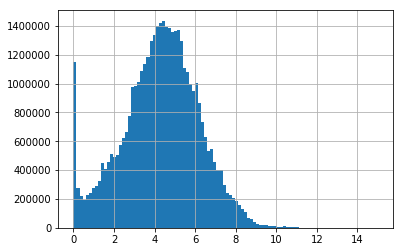

In [71]:
np.log1p(sample_submission['meter_reading']).hist(bins=100)

# Leak score

In [72]:
print ('UCF score = ', np.sqrt(leak_score0))
print ('UCL score = ', np.sqrt(leak_score1))
print ('ASU score = ', np.sqrt(leak_score2))

UCF score =  1.048985941324106
UCL score =  0.7271805148635406
ASU score =  0.8259733122562871
